In [1]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-W2V.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Mounted at /content/drive


['url',
 'price',
 'address',
 'descrip',
 'listed_since',
 'zip_code',
 'size',
 'year',
 'living_area',
 'kind_of_house',
 'building_type',
 'num_of_rooms',
 'num_of_bathrooms',
 'layout',
 'energy_label',
 'insulation',
 'heating',
 'ownership',
 'exteriors',
 'parking',
 'date_list',
 'last_ask_price',
 'last_ask_price_m2',
 'city',
 'log_id',
 'num of tokens per descrip',
 'descrip_en',
 'numerical_price',
 'numerical_price_per_m2',
 'tag',
 'house_category',
 'living_area_float',
 'size_float',
 'zip_code_4_digits',
 'postcode',
 'latitude',
 'longitude',
 'processed_descrip',
 'word2vec_embeddings']

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval



df["word2vec_embeddings"] = df["word2vec_embeddings"].apply(literal_eval).apply(np.array)

x = df["word2vec_embeddings"]
y = df['numerical_price']
# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [3]:

!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.9 MB/s eta 0:00:00


In [4]:
import numpy as np

# Convert x_train and x_test to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)


x_train shape: (10000, 300)
x_test shape: (14403, 300)
y_train shape: (10000,)
y_test shape: (14403,)
Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [5]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_nn, n_trials=50)

[I 2024-01-07 10:59:32,502] A new study created in memory with name: no-name-953abecd-f79c-4626-8d12-dacac852b620


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:09:09,300] Trial 0 finished with value: -0.0012803111641225494 and parameters: {'learning_rate': 0.007329643695894027, 'neurons_layer_1': 624, 'neurons_layer_2': 112, 'neurons_layer_3': 32, 'batch_size': 16, 'epochs': 47, 'regularization': 'l1_l2', 'l1_reg': 0.0010879272935892467, 'l2_reg': 0.04381099538234653}. Best is trial 0 with value: -0.0012803111641225494.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:20:14,621] Trial 1 finished with value: -0.0012839602937673167 and parameters: {'learning_rate': 0.005221881932542511, 'neurons_layer_1': 288, 'neurons_layer_2': 208, 'neurons_layer_3': 208, 'batch_size': 16, 'epochs': 84, 'regularization': 'l1', 'l1_reg': 0.02683316509172458}. Best is trial 0 with value: -0.0012803111641225494.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 11:30:33,082] Trial 2 finished with value: 0.4112791375676485 and parameters: {'learning_rate': 0.00776201048344798, 'neurons_layer_1': 304, 'neurons_layer_2': 112, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 74, 'regularization': 'none'}. Best is trial 2 with value: 0.4112791375676485.


63/63 [==============================] - 0s 6ms/step


[I 2024-01-07 12:27:32,414] Trial 3 finished with value: 0.32420329262595704 and parameters: {'learning_rate': 0.004336457298944931, 'neurons_layer_1': 1024, 'neurons_layer_2': 512, 'neurons_layer_3': 208, 'batch_size': 16, 'epochs': 98, 'regularization': 'l2', 'l2_reg': 2.370788964337525e-05}. Best is trial 2 with value: 0.4112791375676485.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 12:30:38,747] Trial 4 finished with value: 0.4545447062121669 and parameters: {'learning_rate': 0.0010040341158911153, 'neurons_layer_1': 816, 'neurons_layer_2': 304, 'neurons_layer_3': 80, 'batch_size': 128, 'epochs': 41, 'regularization': 'none'}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 12:36:58,520] Trial 5 finished with value: -0.0005693749969651662 and parameters: {'learning_rate': 0.009730287537015391, 'neurons_layer_1': 800, 'neurons_layer_2': 352, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 29, 'regularization': 'l2', 'l2_reg': 0.003135094706513133}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-07 12:38:39,692] Trial 6 finished with value: -0.001003789419748813 and parameters: {'learning_rate': 0.008943772599340863, 'neurons_layer_1': 32, 'neurons_layer_2': 480, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 74, 'regularization': 'l2', 'l2_reg': 0.0017151876132311073}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 12:41:44,524] Trial 7 finished with value: -0.0009010345929822084 and parameters: {'learning_rate': 0.0014021192049010415, 'neurons_layer_1': 928, 'neurons_layer_2': 304, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 31, 'regularization': 'l1', 'l1_reg': 0.0005587585337180586}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 12:55:00,634] Trial 8 finished with value: 0.05861467227568325 and parameters: {'learning_rate': 0.004741069802747381, 'neurons_layer_1': 288, 'neurons_layer_2': 400, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 59, 'regularization': 'l2', 'l2_reg': 1.8939287731222135e-05}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:05:27,525] Trial 9 finished with value: 0.44528635721374554 and parameters: {'learning_rate': 0.002470678862129623, 'neurons_layer_1': 464, 'neurons_layer_2': 192, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 94, 'regularization': 'none'}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:05:56,726] Trial 10 finished with value: 0.32436779969482427 and parameters: {'learning_rate': 0.0001913595608181649, 'neurons_layer_1': 720, 'neurons_layer_2': 32, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 10, 'regularization': 'none'}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:11:33,709] Trial 11 finished with value: 0.40059559649864085 and parameters: {'learning_rate': 0.00232843185999128, 'neurons_layer_1': 528, 'neurons_layer_2': 224, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 50, 'regularization': 'none'}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:14:43,912] Trial 12 finished with value: 0.409162747978203 and parameters: {'learning_rate': 0.0026263780119631466, 'neurons_layer_1': 448, 'neurons_layer_2': 176, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 34, 'regularization': 'none'}. Best is trial 4 with value: 0.4545447062121669.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:31:35,050] Trial 13 finished with value: 0.4954032464071843 and parameters: {'learning_rate': 0.00041361019111463065, 'neurons_layer_1': 832, 'neurons_layer_2': 288, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 100, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 13:32:43,383] Trial 14 finished with value: -0.0008517198558565475 and parameters: {'learning_rate': 0.00016738270194869106, 'neurons_layer_1': 848, 'neurons_layer_2': 288, 'neurons_layer_3': 48, 'batch_size': 64, 'epochs': 7, 'regularization': 'l1_l2', 'l1_reg': 1.04448535193462e-05, 'l2_reg': 0.0997215211722211}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:43:24,426] Trial 15 finished with value: 0.43606905873176505 and parameters: {'learning_rate': 0.0013527766103618552, 'neurons_layer_1': 704, 'neurons_layer_2': 352, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 62, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 13:48:32,180] Trial 16 finished with value: 0.35979672587827183 and parameters: {'learning_rate': 0.003612578420320923, 'neurons_layer_1': 1024, 'neurons_layer_2': 400, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 39, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:50:13,180] Trial 17 finished with value: 0.4053909635442709 and parameters: {'learning_rate': 0.005821061460490202, 'neurons_layer_1': 864, 'neurons_layer_2': 272, 'neurons_layer_3': 144, 'batch_size': 128, 'epochs': 21, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:06:07,542] Trial 18 finished with value: -0.0008464200645370568 and parameters: {'learning_rate': 0.0007096478728172771, 'neurons_layer_1': 672, 'neurons_layer_2': 416, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 71, 'regularization': 'l1_l2', 'l1_reg': 0.07070752767371416, 'l2_reg': 0.00017082032936196006}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 1s 7ms/step


[I 2024-01-07 14:17:46,135] Trial 19 finished with value: 0.44021964403142794 and parameters: {'learning_rate': 0.0033161483186652887, 'neurons_layer_1': 928, 'neurons_layer_2': 320, 'neurons_layer_3': 112, 'batch_size': 64, 'epochs': 86, 'regularization': 'l1', 'l1_reg': 2.6623911463394423e-05}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 14:20:29,538] Trial 20 finished with value: 0.45090891410165546 and parameters: {'learning_rate': 0.0015234762237062854, 'neurons_layer_1': 592, 'neurons_layer_2': 128, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 20, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 14:22:52,872] Trial 21 finished with value: 0.4112976796293877 and parameters: {'learning_rate': 0.0014082249838141235, 'neurons_layer_1': 608, 'neurons_layer_2': 128, 'neurons_layer_3': 80, 'batch_size': 32, 'epochs': 20, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 14:27:37,121] Trial 22 finished with value: 0.45958264300240836 and parameters: {'learning_rate': 0.0018259334747786455, 'neurons_layer_1': 784, 'neurons_layer_2': 16, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 40, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:33:05,640] Trial 23 finished with value: 0.3505681012161901 and parameters: {'learning_rate': 0.002208449099088492, 'neurons_layer_1': 784, 'neurons_layer_2': 16, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 44, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 14:37:21,173] Trial 24 finished with value: 0.4370679591490211 and parameters: {'learning_rate': 0.0008556204794334689, 'neurons_layer_1': 928, 'neurons_layer_2': 256, 'neurons_layer_3': 16, 'batch_size': 128, 'epochs': 52, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 14:46:32,625] Trial 25 finished with value: 0.47210818980111513 and parameters: {'learning_rate': 0.003863870840022136, 'neurons_layer_1': 752, 'neurons_layer_2': 240, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 61, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:57:31,822] Trial 26 finished with value: 0.39945113058046344 and parameters: {'learning_rate': 0.003489119443013327, 'neurons_layer_1': 752, 'neurons_layer_2': 64, 'neurons_layer_3': 48, 'batch_size': 32, 'epochs': 67, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:08:54,483] Trial 27 finished with value: -0.0017750310949641523 and parameters: {'learning_rate': 0.005647146726319573, 'neurons_layer_1': 896, 'neurons_layer_2': 240, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 59, 'regularization': 'l1', 'l1_reg': 0.0030906429805999877}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 15:22:01,612] Trial 28 finished with value: -0.0009339461393473413 and parameters: {'learning_rate': 0.004304502821113876, 'neurons_layer_1': 512, 'neurons_layer_2': 160, 'neurons_layer_3': 256, 'batch_size': 32, 'epochs': 93, 'regularization': 'l1_l2', 'l1_reg': 8.371483382544793e-05, 'l2_reg': 0.00677027666190048}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 15:31:39,643] Trial 29 finished with value: -0.001868004297635384 and parameters: {'learning_rate': 0.007042113382844391, 'neurons_layer_1': 672, 'neurons_layer_2': 64, 'neurons_layer_3': 32, 'batch_size': 32, 'epochs': 80, 'regularization': 'l1_l2', 'l1_reg': 0.0077836869179214695, 'l2_reg': 0.00022519293598679519}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 15:42:17,248] Trial 30 finished with value: 0.4548195187707643 and parameters: {'learning_rate': 0.003193608383525298, 'neurons_layer_1': 608, 'neurons_layer_2': 80, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 100, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:52:23,104] Trial 31 finished with value: 0.4622194360297006 and parameters: {'learning_rate': 0.003115189940260555, 'neurons_layer_1': 576, 'neurons_layer_2': 64, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 99, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:02:16,582] Trial 32 finished with value: 0.4747213418088679 and parameters: {'learning_rate': 0.001998396912363795, 'neurons_layer_1': 752, 'neurons_layer_2': 16, 'neurons_layer_3': 64, 'batch_size': 32, 'epochs': 87, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:11:52,396] Trial 33 finished with value: 0.4743565599553284 and parameters: {'learning_rate': 0.0027814020492487974, 'neurons_layer_1': 560, 'neurons_layer_2': 80, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 86, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:18:13,458] Trial 34 finished with value: 0.4400686282866412 and parameters: {'learning_rate': 0.0028134470215291827, 'neurons_layer_1': 64, 'neurons_layer_2': 96, 'neurons_layer_3': 144, 'batch_size': 16, 'epochs': 86, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:29:09,390] Trial 35 finished with value: 0.48601213982856073 and parameters: {'learning_rate': 0.0020117470550947776, 'neurons_layer_1': 368, 'neurons_layer_2': 160, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 80, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:32:38,319] Trial 36 finished with value: 0.3095293921008452 and parameters: {'learning_rate': 0.001963517979210649, 'neurons_layer_1': 208, 'neurons_layer_2': 144, 'neurons_layer_3': 112, 'batch_size': 64, 'epochs': 90, 'regularization': 'l1', 'l1_reg': 0.00020396337732017146}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:39:30,686] Trial 37 finished with value: -0.0009030631244638876 and parameters: {'learning_rate': 0.0008131041121695747, 'neurons_layer_1': 384, 'neurons_layer_2': 48, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 81, 'regularization': 'l2', 'l2_reg': 0.014607191650468603}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:50:13,695] Trial 38 finished with value: 0.4817690643930395 and parameters: {'learning_rate': 0.0005133830667107225, 'neurons_layer_1': 352, 'neurons_layer_2': 96, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 75, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:04:39,010] Trial 39 finished with value: 0.4649650486437215 and parameters: {'learning_rate': 0.00013460173781917423, 'neurons_layer_1': 336, 'neurons_layer_2': 208, 'neurons_layer_3': 224, 'batch_size': 16, 'epochs': 76, 'regularization': 'l2', 'l2_reg': 0.0005224539005580627}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:14:25,461] Trial 40 finished with value: 0.4163865837269392 and parameters: {'learning_rate': 0.0005211376003581257, 'neurons_layer_1': 208, 'neurons_layer_2': 96, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 92, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:27:11,747] Trial 41 finished with value: 0.4586374753738804 and parameters: {'learning_rate': 0.0017732499725173726, 'neurons_layer_1': 400, 'neurons_layer_2': 96, 'neurons_layer_3': 160, 'batch_size': 16, 'epochs': 80, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:33:56,505] Trial 42 finished with value: 0.4480605358862556 and parameters: {'learning_rate': 0.0012288408325704142, 'neurons_layer_1': 176, 'neurons_layer_2': 32, 'neurons_layer_3': 96, 'batch_size': 16, 'epochs': 87, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:44:55,590] Trial 43 finished with value: 0.46079573227386883 and parameters: {'learning_rate': 0.0009665521624254403, 'neurons_layer_1': 272, 'neurons_layer_2': 112, 'neurons_layer_3': 128, 'batch_size': 16, 'epochs': 95, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:52:03,504] Trial 44 finished with value: 0.33028535815750915 and parameters: {'learning_rate': 0.0021978704469263685, 'neurons_layer_1': 512, 'neurons_layer_2': 176, 'neurons_layer_3': 144, 'batch_size': 32, 'epochs': 68, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 17:58:27,524] Trial 45 finished with value: 0.4210605278059291 and parameters: {'learning_rate': 0.002684771756353688, 'neurons_layer_1': 352, 'neurons_layer_2': 144, 'neurons_layer_3': 112, 'batch_size': 32, 'epochs': 75, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 18:03:42,765] Trial 46 finished with value: 0.4538863028631847 and parameters: {'learning_rate': 0.0005509157885594366, 'neurons_layer_1': 448, 'neurons_layer_2': 48, 'neurons_layer_3': 192, 'batch_size': 64, 'epochs': 82, 'regularization': 'l2', 'l2_reg': 8.836366677378005e-05}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 18:19:34,105] Trial 47 finished with value: 0.41641322507352607 and parameters: {'learning_rate': 0.004166926554302841, 'neurons_layer_1': 256, 'neurons_layer_2': 352, 'neurons_layer_3': 176, 'batch_size': 16, 'epochs': 89, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 18:30:30,541] Trial 48 finished with value: -0.0008608052591128513 and parameters: {'learning_rate': 0.0017996153433410187, 'neurons_layer_1': 416, 'neurons_layer_2': 192, 'neurons_layer_3': 96, 'batch_size': 32, 'epochs': 96, 'regularization': 'l1', 'l1_reg': 0.012088048084960938}. Best is trial 13 with value: 0.4954032464071843.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 18:41:45,538] Trial 49 finished with value: 0.4691093103642786 and parameters: {'learning_rate': 0.0011494707107835463, 'neurons_layer_1': 544, 'neurons_layer_2': 320, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 77, 'regularization': 'none'}. Best is trial 13 with value: 0.4954032464071843.


<ipython-input-6-b7f3a9c196e1>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

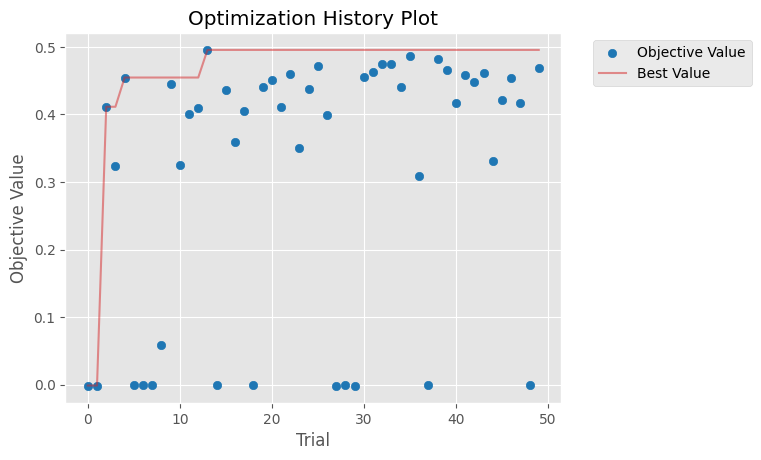

In [6]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

<ipython-input-7-62749383f84c>:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-7-62749383f84c>:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
<ipython-input-7-62749383f84c>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


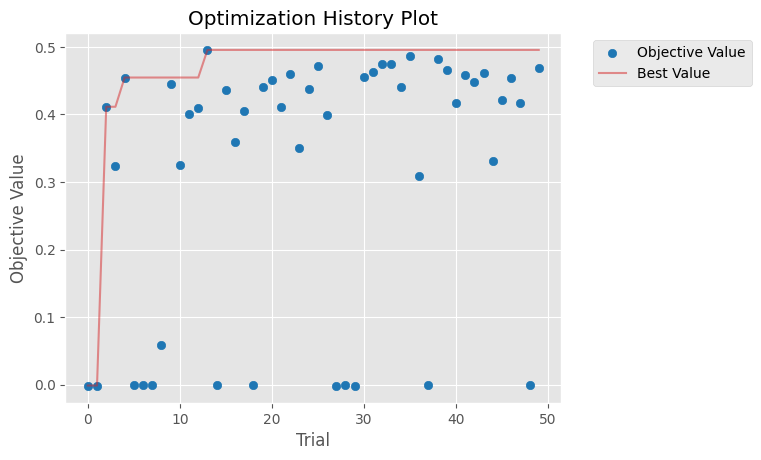

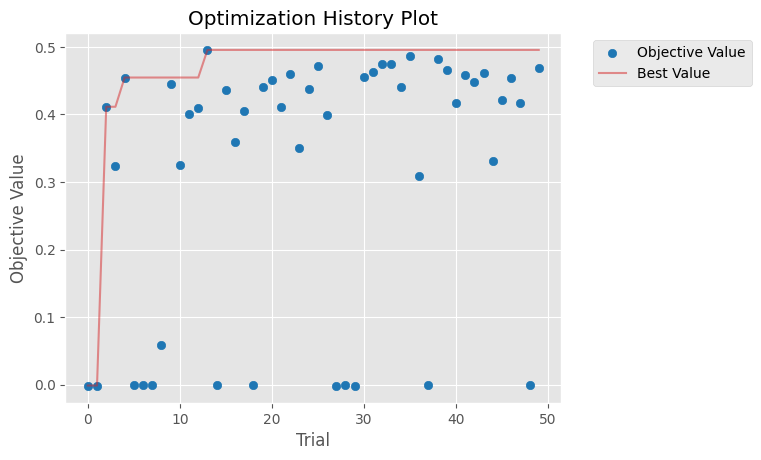

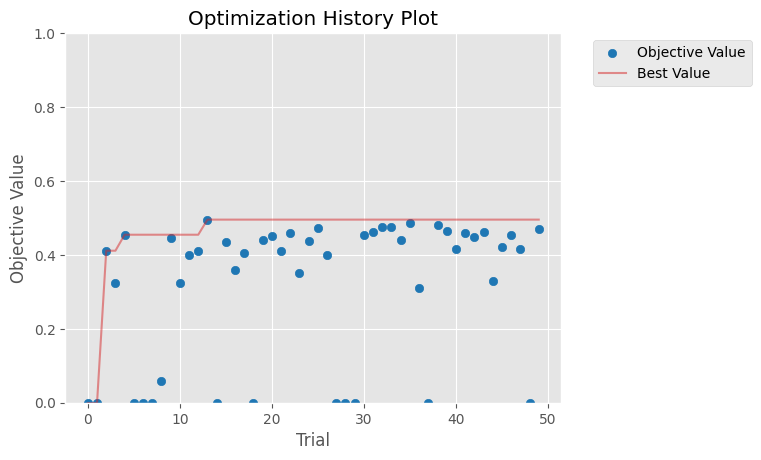

In [7]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna.visualization.matplotlib.plot_optimization_history(study_svr)
optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 1)

# Show the plot
plt.show()